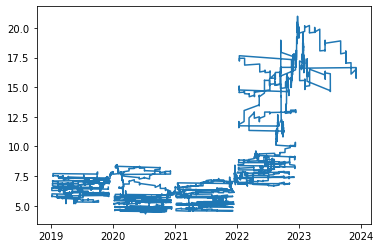

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn

#Importing the dataset

akbank_data = pd.read_csv("C:\\Users\\ERALP\\OneDrive\\Desktop\\Software Engineering\\SWE599---Financial-Time-Series-Volatility-and-Return-Forecasting\\Code\\akbank_data.csv")


akbank_data['Datetime'] = pd.to_datetime(akbank_data['Date'] + " " + akbank_data['Hour'])
akbank_data.set_index('Datetime')
akbank_data.drop(['Date', 'Hour'], axis=1, inplace=True)
akbank_data = akbank_data[['Datetime','Close',]]

plt.plot(akbank_data['Datetime'], akbank_data['Close'])



In [86]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device


'cuda:0'

In [87]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Datetime', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 10
shifted_df = prepare_dataframe_for_lstm(akbank_data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Datetime,,,,,,,,,,,
2019-02-13 09:00:00,6.45,6.40,6.40,6.39,6.43,6.39,6.49,6.48,6.57,6.52,6.57
2019-02-13 10:00:00,6.39,6.45,6.40,6.40,6.39,6.43,6.39,6.49,6.48,6.57,6.52
2019-02-13 11:00:00,6.32,6.39,6.45,6.40,6.40,6.39,6.43,6.39,6.49,6.48,6.57
2019-02-13 12:00:00,6.32,6.32,6.39,6.45,6.40,6.40,6.39,6.43,6.39,6.49,6.48
2019-02-13 13:00:00,6.30,6.32,6.32,6.39,6.45,6.40,6.40,6.39,6.43,6.39,6.49
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 17:00:00,15.92,16.12,16.10,16.05,16.05,16.07,16.02,16.16,15.94,15.99,15.99
2023-02-21 18:00:00,15.90,15.92,16.12,16.10,16.05,16.05,16.07,16.02,16.16,15.94,15.99
2023-02-22 09:00:00,15.89,15.90,15.92,16.12,16.10,16.05,16.05,16.07,16.02,16.16,15.94


In [88]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[ 6.45,  6.4 ,  6.4 , ...,  6.57,  6.52,  6.57],
       [ 6.39,  6.45,  6.4 , ...,  6.48,  6.57,  6.52],
       [ 6.32,  6.39,  6.45, ...,  6.49,  6.48,  6.57],
       ...,
       [15.89, 15.9 , 15.92, ..., 16.02, 16.16, 15.94],
       [16.13, 15.89, 15.9 , ..., 16.07, 16.02, 16.16],
       [16.17, 16.13, 15.89, ..., 16.05, 16.07, 16.02]])

In [89]:
shifted_df_as_np.shape

(9982, 11)

In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np= scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.74325135, -0.74925015, -0.74925015, ..., -0.72885423,
        -0.73485303, -0.72885423],
       [-0.75044991, -0.74325135, -0.74925015, ..., -0.73965207,
        -0.72885423, -0.73485303],
       [-0.75884823, -0.75044991, -0.74325135, ..., -0.73845231,
        -0.73965207, -0.72885423],
       ...,
       [ 0.38932214,  0.3905219 ,  0.39292142, ...,  0.40491902,
         0.42171566,  0.39532094],
       [ 0.41811638,  0.38932214,  0.3905219 , ...,  0.41091782,
         0.40491902,  0.42171566],
       [ 0.42291542,  0.41811638,  0.38932214, ...,  0.4085183 ,
         0.41091782,  0.40491902]])

In [91]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((9982, 10), (9982,))

In [92]:
X = dc(np.flip(X, axis=1))
X

array([[-0.72885423, -0.73485303, -0.72885423, ..., -0.75044991,
        -0.74925015, -0.74925015],
       [-0.73485303, -0.72885423, -0.73965207, ..., -0.74925015,
        -0.74925015, -0.74325135],
       [-0.72885423, -0.73965207, -0.73845231, ..., -0.74925015,
        -0.74325135, -0.75044991],
       ...,
       [ 0.39532094,  0.42171566,  0.40491902, ...,  0.41691662,
         0.39292142,  0.3905219 ],
       [ 0.42171566,  0.40491902,  0.41091782, ...,  0.39292142,
         0.3905219 ,  0.38932214],
       [ 0.40491902,  0.41091782,  0.4085183 , ...,  0.3905219 ,
         0.38932214,  0.41811638]])

In [93]:
split_index = int(len(X) * 0.8)
split_index

7985

In [94]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7985, 10), (1997, 10), (7985,), (1997,))

In [95]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7985, 10, 1), (1997, 10, 1), (7985, 1), (1997, 1))

In [96]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([7985, 10, 1]),
 torch.Size([1997, 10, 1]),
 torch.Size([7985, 1]),
 torch.Size([1997, 1]))

In [97]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [98]:
train_dataset


In [99]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [100]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


In [101]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [102]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [103]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [104]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.311
Batch 200, Loss: 0.061
Batch 300, Loss: 0.015
Batch 400, Loss: 0.012
Batch 500, Loss: 0.012

Val Loss: 0.562
***************************************************

Epoch: 2
Batch 100, Loss: 0.012
Batch 200, Loss: 0.011
Batch 300, Loss: 0.011
Batch 400, Loss: 0.010
Batch 500, Loss: 0.009

Val Loss: 0.445
***************************************************

Epoch: 3
Batch 100, Loss: 0.008
Batch 200, Loss: 0.007
Batch 300, Loss: 0.005
Batch 400, Loss: 0.003
Batch 500, Loss: 0.001

Val Loss: 0.267
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.249
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.247
***************************************************

Epoch: 6
Batch 100, Loss: 0.00

In [105]:
import numpy as np

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

RuntimeError: Numpy is not available

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

In [ ]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

In [ ]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

In [ ]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()